### Реализация U-Net на TensorFlow

In [1]:
import tensorflow as tf
import os
import glob
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
train_val_images = glob.glob("train/*")
train_val_images = sorted(train_val_images)
train_val_images = [s.split("\\")[-1].split(".")[0] for s in train_val_images]
print(len(train_val_images))  # 5088

5088


In [3]:
sample_sub = pd.read_csv("sample_submission.csv")
sample_sub.head(2)

,img,rle_mask
0,0004d4463b50_01.jpg,1 1
1,0004d4463b50_02.jpg,1 1


In [4]:
train_images, val_images = train_test_split(train_val_images, test_size=0.1, random_state=42)
print(train_images[0], val_images[0])

69915dab0755_11 1ba84b81628e_14


In [5]:
print(len(train_images), len(val_images))  # (4579, 509)

4579 509


In [6]:
img_size = 576

In [7]:
class CustomImageDataset(tf.keras.utils.Sequence):
    def __init__(self, img_ids, transform=None):
        self.img_ids = img_ids
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_path = os.path.join("train", img_id + ".jpg")
        mask_path = os.path.join("train_masks", img_id + "_mask.gif")
        image = Image.open(img_path)
        image = image.resize((img_size, img_size))
        mask = Image.open(mask_path).convert("L")
        mask = mask.resize((img_size, img_size))
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [8]:
training_data = CustomImageDataset(train_images, tf.keras.preprocessing.image.img_to_array)
val_data = CustomImageDataset(val_images, tf.keras.preprocessing.image.img_to_array)

In [9]:
for x, y in training_data:
    print(x.shape)  # (576, 576, 3)
    print(y.shape)  # (576, 576, 1)
    break

(576, 576, 3)
(576, 576, 1)


In [10]:
train_dataloader = tf.data.Dataset.from_generator(lambda: training_data, output_signature=(
    tf.TensorSpec(shape=(img_size, img_size, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(img_size, img_size, 1), dtype=tf.float32)
)).batch(4).shuffle(buffer_size=4)

In [11]:
val_dataloader = tf.data.Dataset.from_generator(lambda: val_data, output_signature=(
    tf.TensorSpec(shape=(img_size, img_size, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(img_size, img_size, 1), dtype=tf.float32)
)).batch(4).shuffle(buffer_size=4)

In [12]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device} device")

Using cpu device


In [13]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, in_channels: int, out_channels: int):
        super(ConvBlock, self).__init__()
        self.block = tf.keras.Sequential([
            tf.keras.layers.Conv2D(in_channels, (3, 3), strides=(1, 1), padding="same"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(out_channels, (3, 3), strides=(1, 1), padding="same"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU()
        ])

    def call(self, x: tf.Tensor):
        return self.block(x)

In [14]:
class CopyAndCrop(tf.keras.layers.Layer):
    def call(self, x: tf.Tensor, encoded: tf.Tensor):
        _, h, w, _ = encoded.shape
        crop = tf.image.resize_with_crop_or_pad(x, h, w)
        output = tf.concat((x, crop), axis=-1)

        return output

In [15]:
class UNet(tf.keras.Model):
    def __init__(self, in_channels: int, out_channels: int):
        super(UNet, self).__init__()

        self.encoders = [
            ConvBlock(in_channels, 32),
            ConvBlock(64, 64),
            ConvBlock(128, 128),
        ]
        self.down_sample = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
        self.copyAndCrop = CopyAndCrop()
        self.decoders = [
            ConvBlock(128, 128),
            ConvBlock(64, 64),
            ConvBlock(32, 32),
        ]

        self.up_samples = [
            tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2)),
            tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2)),
            tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2)),
        ]

        self.bottleneck = ConvBlock(64, 128)
        self.final_conv = tf.keras.layers.Conv2D(out_channels, (1, 1), strides=(1, 1))

    def call(self, x: tf.Tensor):
        # encode
        encoded_features = []
        for enc in self.encoders:
            x = enc(x)
            encoded_features.append(x)
            x = self.down_sample(x)

        x = self.bottleneck(x)

        # decode
        for idx, denc in enumerate(self.decoders):
            x = self.up_samples[idx](x)
            encoded = encoded_features.pop()
            x = self.copyAndCrop(x, encoded)
            x = denc(x)

        output = self.final_conv(x)
        return output

In [16]:
model = UNet(in_channels=3, out_channels=1)
model.build((None, img_size, img_size, 3))  # Построение модели с указанием размерности входных данных
model.summary()

Model: "u_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_block (ConvBlock)      multiple                  1120      
                                                                 
 conv_block_1 (ConvBlock)    multiple                  55936     
                                                                 
 conv_block_2 (ConvBlock)    multiple                  222464    
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 copy_and_crop (CopyAndCrop)  multiple                 0         
                                                                 
 conv_block_3 (ConvBlock)    multiple                  443648    
                                                             

In [17]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00000002)

In [18]:
@tf.function
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [19]:
def train(dataloader, epochs):
    size = 4579  # len(train_images)
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n-------------------------------")
        for batch, (X, y) in enumerate(dataloader):
            X = tf.cast(X, tf.float32)
            y = tf.cast(y, tf.float32)
            loss = train_step(X, y)

            if batch % 10 == 0:
                current = (batch + 1) * X.shape[0]
                print(f"loss: {loss:.7f}  [{current:>5d}/{size:>5d}]")

In [20]:
epochs = 2
train(train_dataloader, epochs)
print("Done!")

Epoch 1
-------------------------------
loss: 0.6720914  [    4/ 4579]
loss: 0.6739830  [   44/ 4579]
loss: 0.6598163  [   84/ 4579]
loss: 0.6794295  [  124/ 4579]
loss: 0.6606229  [  164/ 4579]
loss: 0.6854300  [  204/ 4579]
loss: 0.6553655  [  244/ 4579]
loss: 0.6221138  [  284/ 4579]
loss: 0.6172931  [  324/ 4579]
loss: 0.6378007  [  364/ 4579]
loss: 0.6329242  [  404/ 4579]
loss: 0.6216270  [  444/ 4579]
loss: 0.5565678  [  484/ 4579]
loss: 0.6434284  [  524/ 4579]
loss: 0.6065860  [  564/ 4579]
loss: 0.5879599  [  604/ 4579]
loss: 0.5863040  [  644/ 4579]
loss: 0.5560344  [  684/ 4579]
loss: 0.6187851  [  724/ 4579]
loss: 0.5648958  [  764/ 4579]
loss: 0.5969347  [  804/ 4579]
loss: 0.6178327  [  844/ 4579]
loss: 0.6117022  [  884/ 4579]
loss: 0.5730085  [  924/ 4579]
loss: 0.5352526  [  964/ 4579]
loss: 0.5039527  [ 1004/ 4579]
loss: 0.5134011  [ 1044/ 4579]
loss: 0.6075137  [ 1084/ 4579]
loss: 0.6196773  [ 1124/ 4579]
loss: 0.5873153  [ 1164/ 4579]
loss: 0.5620608  [ 1204/ 4579]

In [120]:
def plot_images(images, mask=False):
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(2, len(images)//2, figsize=(10, 8))
    for i, img in enumerate(images):
        img = img / 255.0  # Нормализация значений пикселей
        if i < len(images) // 2:
            ax = axes[0, i]
        else:
            ax = axes[1, i - len(images) // 2]
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [121]:
def visualize_result(dataloader):
    tr_imgs = []
    msk_imgs = []

    for x, y in dataloader:
        x = x.numpy()
        pred = model.predict(x)

        for i in range(x.shape[0]):
            tr_img = x[i]
            msk_img = pred[i].reshape((img_size, img_size))
            tr_imgs.append(tr_img)
            msk_imgs.append(msk_img)

        break

    plot_images(tr_imgs, mask=False)
    plot_images(msk_imgs, mask=False)

1/1 [==============================] - 2s 2s/step


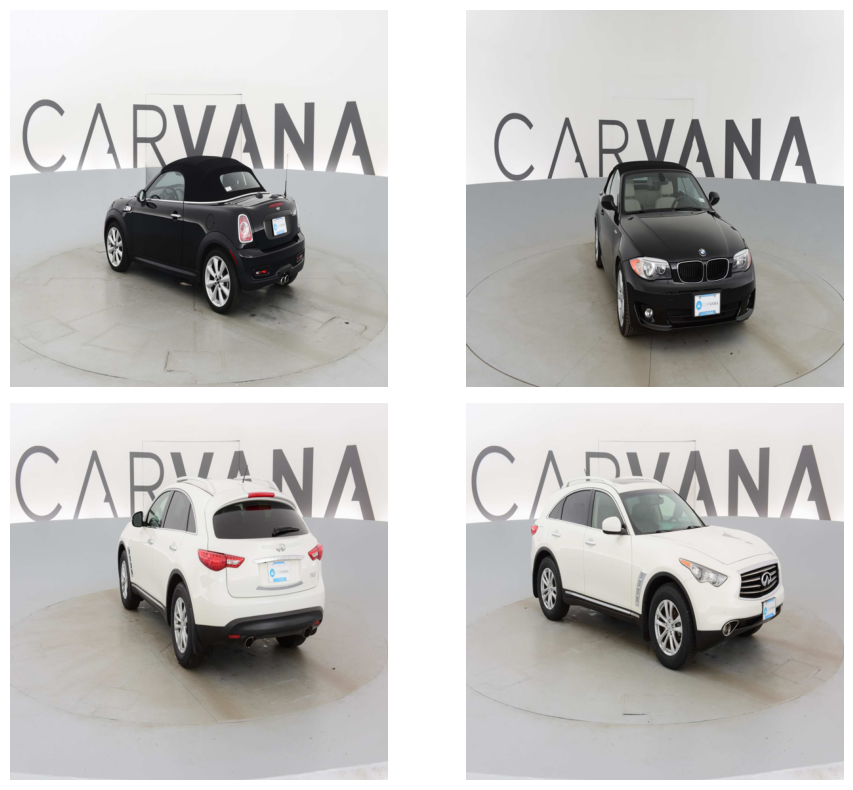

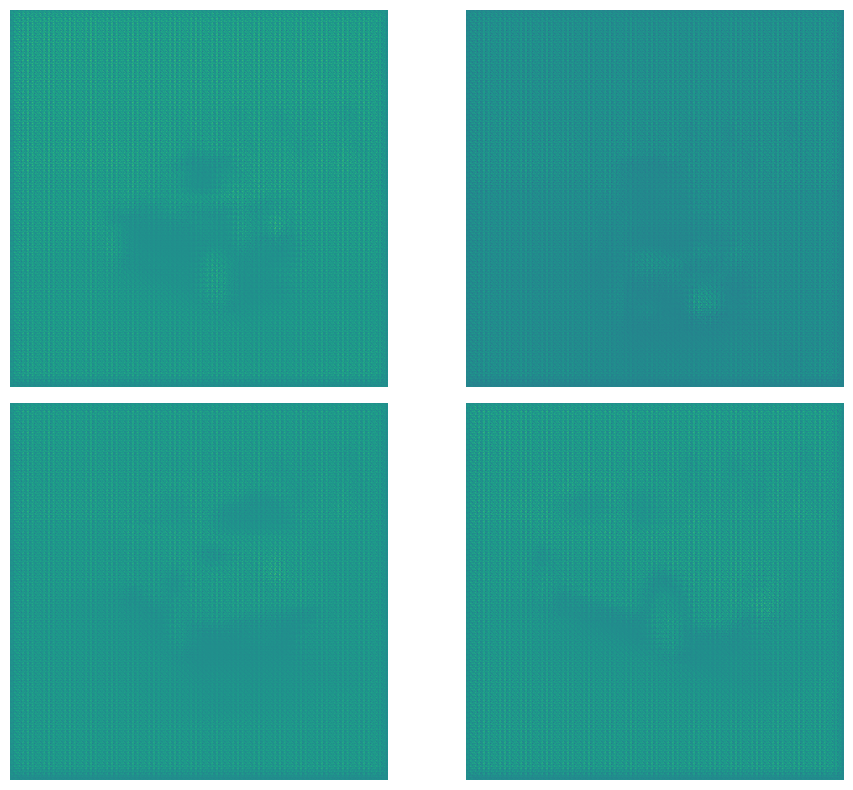

In [122]:
visualize_result(val_dataloader)

### Анализ нейронной сети:
1. Архитектура:
- Нейронная сеть использует модель UNet, которая широко применяется для задач сегментации изображений.
- Архитектура UNet состоит из кодировщика (энкодера), в котором происходит последовательное сжатие информации, и декодировщика (декодера), в котором происходит последовательное расширение и восстановление информации.
- В энкодере используются блоки свертки `ConvBlock` и операция пулинга `MaxPool2D` для извлечения признаков на разных уровнях.
- В декодере используются операции обратного пулинга `Conv2DTranspose`, операция объединения и обрезки `CopyAndCrop` и блоки свертки `ConvBlock` для постепенного восстановления информации.
- Финальный слой свертки используется для получения выходного изображения.
2. Входные данные:
- Используются изображения и соответствующие маски для обучения модели.
- Изображения изменяются до размера `img_size` с помощью функции `resize()`.
- Маски также изменяются до размера `img_size` и преобразуются в одноканальные изображения.
3. Обучение:
- Используется функция потерь `BinaryCrossentropy` для бинарной классификации.
- Оптимизатор Adam используется для обновления весов модели.
- В цикле обучения модели выполняется проход по обучающему датасету с помощью функции `train_step()`.
- В каждой итерации вычисляется потеря и обновляются веса модели.
- Информация о потере и прогрессе выводится на экран.
4. Результаты:
- Выводится сводка модели, показывающая количество параметров и форму каждого слоя.
- После обучения модели вызывается функция `visualize_result()`, которая отображает исходные изображения и предсказанные маски для валидационного датасета.

### Что помогло улучшить точность нейронной сети:
- Применение архитектуры UNet, специально разработанной для сегментации изображений.
- Использование блоков свертки `ConvBlock` с операциями нормализации `BatchNormalization` и активации `ReLU` может способствовать извлечению релевантных признаков.
- Операции пулинга `MaxPool2D` и обратного пулинга `Conv2DTranspose` позволяют сжимать и восстанавливать пространственную информацию, сохраняя контекст.
- Операция объединения и обрезки `CopyAndCrop` помогает объединять признаки с разных уровней и сохранять детали.
- Использование функции потерь `BinaryCrossentropy` и оптимизатора Adam с настроенными параметрами может способствовать лучшей сходимости и обучению модели.

### Функция потерь `BinaryCrossentropy`с параметром `from_logits=True`:
- В представленной нейронной сети функция потерь `BinaryCrossentropy` устанавливается с параметром `from_logits=True`. Это означает, что выходы модели (предсказания) будут необработанными значениями или логитами (до применения функции активации).
- При использовании `from_logits=True` функция потерь `BinaryCrossentropy` применяет логистическую функцию к предсказаниям и истинным меткам, чтобы получить значения вероятностей. Затем вычисляется потеря на основе вероятностей.
- Поскольку в этой ситуации функция потерь принимает необработанные значения (логиты), она может выдавать отрицательные значения потери. Однако, после применения функции активации к предсказаниям модели, значения потери будут положительными.